This notebook contains the experiments for the case where model have access to initial web context.

In [10]:
import sys
sys.path.append('..')

import argparse
import torch

import requests
from PIL import Image
import json
import base64
from io import BytesIO

from openai import OpenAI
import openai

from utils.data import get_data, show_data
from utils.stored_retrieval import retrieve_summary
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt

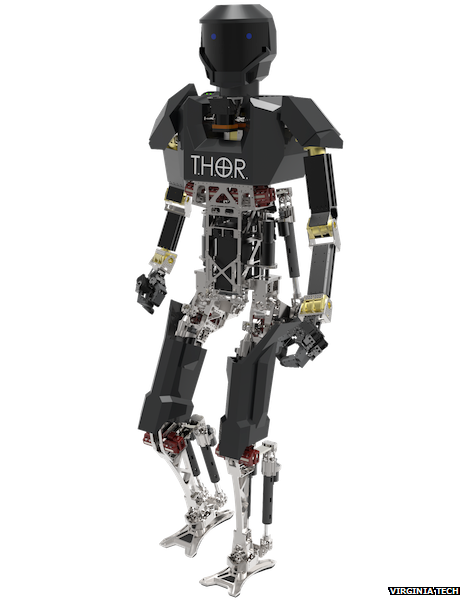

Caption:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
Ground truth:  False


In [54]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 3

data_idx = 4

image, caption, image_path, annotation = get_data(data_idx)
image_size = image.size
summary_key = str(annotation['id'])+"_"+str(annotation["image_id"])
summary = retrieve_summary(summary_key)

display(image)
print("Caption: ", caption)
print("Ground truth: ", annotation['falsified'])

In [55]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

encoded_image_path = encode_image(image_path)

In [56]:
class OpenAIModel:
    def __init__(self,model_name):
        # Initialize conversation with a system message
        self.conversation = [{"role": "system", "content": """You are a misinformation detection expert in the news domain. You will look at image-caption pairs and decide if the given image is rightly used in the given news context. To further assist you, a summary of news articles related to the image will be provided.
                    Based on this, you need to decide if the caption belongs to the image or if it is being used to spread false information to mislead people.
                    Note that the image is real. It has not been digitally altered. 
                    Carefully examine the image for any known entities, people, watermarks, dates, landmarks, flags, text, logos and other details which could give you important information to better explain your answer.
                    Remember in news articles images and captions are often related contextually and the caption need not exactly describe the image.
                    The goal is to consider the contextual relationship between the image and caption based on the news articles and correctly identify if the image caption pair is misinformation or not and to explain your answer in detail.
                    Think step by step and plan a detailed explanation for your answer."""}]
        self.model = model_name
        self.client = OpenAI(api_key="sk-proj-yQks4VWKSCjujaJT5k4oT3BlbkFJRU5d5lxleJIQ4h1dqoCW")
    def add_message(self, role, content):
        # Adds a message to the conversation.
        self.conversation.append({"role": role, "content": content})
    def generate_response(self, prompt):
        # Add user prompt to conversation
        self.add_message("user", prompt)
        # Make a request to the API using the chat-based endpoint with conversation context
        response = self.client.chat.completions.create(model=self.model, messages=self.conversation, max_tokens=512)
        # Extract the response
        assistant_response = response.choices[0].message.content
        # Add assistant response to conversation
        self.add_message("assistant", assistant_response)
        # Return the response
        return assistant_response

In [57]:
model_name = "gpt-4o"
model_a = OpenAIModel(model_name)
model_b = OpenAIModel(model_name)

model_a.add_message("user", [{"type":"text", "text":"This is the image."},
          {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image_path}"}}])
model_b.add_message("user", [{"type":"text", "text":"This is the image."},
          {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image_path}"}}])

In [58]:
prompts = ["""This is the caption: {}. This is the summary of true news articles related to the image: {}.
Now based on all the information, give a definite YES or NO answer to this question: IS THIS IMAGE-CAPTION PAIR MISINFORMATION?
""".format(caption, summary),
"""This is what I think about the same image-caption pair: [RESP].
                    Do you agree with me? If you think I am wrong then convince me why.
                    Clearly state your reasoning and tell me if I am missing out on some important information or am making some logical error.
                    Use this information to improve/correct your answer.
                    At the end give a definite YES or NO answer to this question: IS THIS IMAGE-CAPTION PAIR MISINFORMATION?""",
"""I see what you mean and this is what I think: [RESP]. Do you agree with me?
                If not then point out the inconsistencies in my argument (e.g. location, time or person related logical confusion) and explain why you are correct. 
                If you disagree with me then clearly state why and what information I am overlooking.
                I want you to help me improve my argument and explanation. 
                Don't give up your original opinion without clear reasons, DO NOT simply agree with me without proper reasoning.
                At the end give a definite YES or NO answer to this question: IS THIS IMAGE-CAPTION PAIR MISINFORMATION?"""
]


In [59]:
for round in range(num_rounds+1):
    if round == 0:
        output_a = model_a.generate_response(prompts[round])
        print("AGENT-1: ", output_a)
        output_b = model_b.generate_response(prompts[round])
        print("AGENT-2: ", output_b)
        continue
    else:
        prompt_a = prompts[round].replace("[RESP]", output_b)
        prompt_b = prompts[round].replace("[RESP]", output_a)
        output_a = model_a.generate_response(prompt_a)
        print("AGENT-1: ", output_a)
        output_b = model_b.generate_response(prompt_b)
        print("AGENT-2: ", output_b)
    if "YES" in output_a and "YES" in output_b:
        print("********** Models agree on YES ************")
        break
    elif "NO" in output_a and "NO" in output_b:
        print("********** Models agree on NO ************")
        break    

AGENT-1:  NO

This image-caption pair does not spread misinformation. 

Here's the detailed explanation for the answer:

- The image shows a robot labeled "THOR" with "VIRGINIA TECH" in the corner, which matches the description of Virginia Tech's robot for the DARPA Robotics Challenge.

- The caption states: "Virginia Tech's Thor includes artificial elastic muscles. It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage." This fits into the timeline and context provided in the summary.

- The news summary mentions Virginia Tech as one of the teams participating in the DARPA Robotics Challenge and explains that teams will be developing hardware and software to assist in emergency responses, aligning with the purpose of the THOR robot.

Thus, the contextual relationship between the image, caption, and news summary supports the provided information, confirming that there is no intention to mislead.
AGENT-2:  NO

The caption and the summary of the n